In [1]:
! pip install clockify  # clockify-api-client has some problems with getting all time entries
! pip install clockify-api-client  # clockify has some problems with projects

In [2]:
from datetime import datetime
from dateutil import parser
from clockify import factories
from clockify_api_client.client import ClockifyAPIClient
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import logging

In [3]:
### Parameters ###

# start and the end of the sprint (Unix epoch time to avoid timezone problems)
start_of_sprint = 1643056200  
end_of_sprint = 1643315400

# Excel file including tasks 
file_path = 'Tasks.xlsx'
sheet_name = 'Sprint1'

# clockify api key
api_key = '<API KEY>'  # Find it in https://clockify.me/user/settings
workspace_name = ''  # name of the workspace in clockify (leave it blank if you have just one workspace) 
user_name = '' # Leave it blank if you are the only user

In [4]:
# Helper functions
def match(done_project, done_task, target_task):
  target_task = str(target_task).strip().lower()
  if target_task.startswith('project:'):
    target_project = target_task[8:].strip()
    done_project = str(done_project).lower()
    return done_project == target_project
  elif target_task.startswith('task:'):
    target_desc = target_task[5:].strip()
    done_task = str(done_task).lower()
    return target_desc in done_task
  else:
    raise 'Unknown task description!'

def process_entry(done, task):
  elapsed = 0
  if match(projects[done['projectId']], done['description'], task['Description']):
    duration = done['timeInterval']['duration']
    r = re.match(r"PT(\d*H)?(\d*M)?(\d*S)?", duration)
    if r.group(1):
      elapsed += int(r.group(1)[:-1])
    if r.group(2):
      elapsed += int(r.group(2)[:-1])/60
    if r.group(3):
      elapsed += int(r.group(3)[:-1])/3600
    
  return elapsed

In [5]:
# Obtain user_id
for workspace in factories.Workspace(api_key=api_key).get_all_workspaces():
  if (workspace['name'] == workspace_name) or (workspace_name == ''):
    workspace_id = workspace['id']

# obtain workspace_id
for user in factories.User(api_key=api_key).get_all_workspace_users(workspace_id=workspace_id):
  if (user['name'] == user_name) or (user_name == ''):
    user_id = user['id']

# Obtain project_ids
client = ClockifyAPIClient().build(api_key, 'api.clockify.me/v1')
projects = dict()
for project in client.projects.get_projects(workspace_id):
  if not project['archived']:
    projects[project['id']] = project['name']

# Read tasks
tasks = pd.read_excel(file_path, sheet_name=sheet_name)

INFO:root:Start function: get_all_workspaces
INFO:root:Start function: get_all_workspace_users


In [6]:
# Process time entries

results = [[0.0, float(d['Estimated Hours']), d['Description']] for i,d in tasks.iterrows()]  # (spend_hours, estimated_hours)

processed_ids = [] # get_all_time_entry_user returns each entry multiple times, so we need to check them. 
for entry in factories.TimeEntry(api_key=api_key).get_all_time_entry_user(workspace_id=workspace_id, user_id=user_id):
  date = parser.parse(entry['timeInterval']['start']).timestamp()
  if (start_of_sprint <= date < end_of_sprint) and (entry['id'] not in processed_ids):
    entry_matched = False
    processed_ids.append(entry['id'])
    for i, t in tasks.iterrows():
      elapsed_time = process_entry(entry, t)
      results[i][0] += elapsed_time
      if elapsed_time > 0:
        if entry_matched:
          logging.warning(f"\'{entry['description']}\' matched multiple tasks!")
        else:
          entry_matched = True

INFO:root:Start function: get_all_time_entry_user


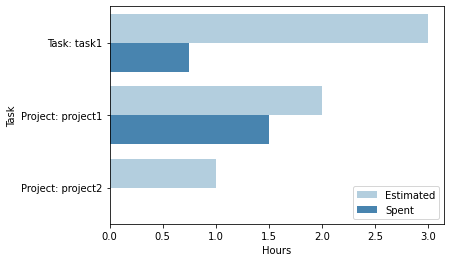

In [7]:
# Plot results
df = []
for r in results:
  df.append(['Spent', r[0], r[2]])
  df.append(['Estimated', r[1], r[2]])
df = pd.DataFrame(df, columns=['Type', 'Hours', 'Task']).sort_values(['Type', 'Hours'], ascending=[True, False])
g = sns.barplot(x="Hours", y="Task",
            hue="Type", data=df,
            palette='Blues')
g.legend_.set_title(None)